<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#CNN-for-IMDB-Movie-Review-classification" data-toc-modified-id="CNN-for-IMDB-Movie-Review-classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>CNN for IMDB Movie Review classification</a></span><ul class="toc-item"><li><span><a href="#Access-IMDB-Dataset" data-toc-modified-id="Access-IMDB-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Access IMDB Dataset</a></span></li><li><span><a href="#Transform-data-into-sequences-of-integers" data-toc-modified-id="Transform-data-into-sequences-of-integers-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform data into sequences of integers</a></span></li><li><span><a href="#Prepare-training--and-validation-data" data-toc-modified-id="Prepare-training--and-validation-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prepare training- and validation data</a></span></li><li><span><a href="#Load-glove-word-embeddings" data-toc-modified-id="Load-glove-word-embeddings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Load glove word-embeddings</a></span></li><li><span><a href="#Bidirectional-LSTM" data-toc-modified-id="Bidirectional-LSTM-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Bidirectional LSTM</a></span><ul class="toc-item"><li><span><a href="#Prepare-Embedding-Matrix-and--Layer" data-toc-modified-id="Prepare-Embedding-Matrix-and--Layer-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Prepare Embedding Matrix and -Layer</a></span></li><li><span><a href="#Define-architecture" data-toc-modified-id="Define-architecture-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Define architecture</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Train Network</a></span></li></ul></li><li><span><a href="#Bidirectional-LSTM-architecture-with-Attention" data-toc-modified-id="Bidirectional-LSTM-architecture-with-Attention-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Bidirectional LSTM architecture with Attention</a></span><ul class="toc-item"><li><span><a href="#Define-Custom-Attention-Layer" data-toc-modified-id="Define-Custom-Attention-Layer-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Define Custom Attention Layer</a></span></li><li><span><a href="#Prepare-Embedding-Matrix-and--Layer" data-toc-modified-id="Prepare-Embedding-Matrix-and--Layer-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Prepare Embedding Matrix and -Layer</a></span></li><li><span><a href="#Define-Architecture" data-toc-modified-id="Define-Architecture-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Define Architecture</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-1.6.4"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span>Train Network</a></span></li></ul></li></ul></li></ul></div>

# CNN for IMDB Movie Review classification
* Author: Johannes Maucher
* Last Update: 20.02.2018

The IMDB Movie Review corpus is a standard dataset for the evaluation of text-classifiers. It consists of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). In a series of notebooks this dataset is applied for the development and evaluation of 
* [Convolutional Neural Networks (CNN)](K05CNN.ipynb)
* [Bidirectional LSTMs](K05biDirectionalLSTM.ipynb) (this notebook)
* [Hierarchical Attention Network (HAN)](K05HAN.ipynb)

Goals of the experiments in these notebooks are
* show how to configure advanced network architectures in Keras
* compare these advanced architectures

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os

os.environ['KERAS_BACKEND']='tensorflow'
#os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


## Access IMDB Dataset

In [2]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [3]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [4]:
#data_train = pd.read_csv('./Data/imdb/labeledTrainData.tsv', sep='\t')
data_train = pd.read_csv('../Data/imdb/labeledTrainData.tsv', sep='\t')
print(data_train.shape)

texts = []
labels = []

for idx in range(data_train.review.shape[0]):
    text = BeautifulSoup(data_train.review[idx],"html5lib")
    texts.append(clean_str(text.get_text()))
    labels.append(data_train.sentiment[idx])
    

(25000, 3)


##  Transform data into sequences of integers

In [5]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 81503 unique tokens.


Shape of data tensor: (25000, 1000)
Shape of label tensor: (25000, 2)


## Prepare training- and validation data

In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Traing and validation set number of positive and negative reviews')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Traing and validation set number of positive and negative reviews
[10039.  9961.]
[2461. 2539.]



## Load glove word-embeddings

In [7]:
#GLOVE_DIR = "./Data/glove.6B"
GLOVE_DIR = "../../../../DataSets/glove" #deepthought
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

FileNotFoundError: [Errno 2] No such file or directory: '../../../../DataSets/glove/glove.6B.100d.txt'

##  Bidirectional LSTM
###  Prepare Embedding Matrix and -Layer

In [9]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Define architecture

In [10]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm)
model = Model(sequence_input, preds)

### Train Network

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

print("model fitting - Bidirectional LSTM")
model.summary()

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         8150400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 8,311,602
Trainable params: 161,202
Non-trainable params: 8,150,400
_________________________________________________________________


In [12]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 877s 44ms/step - loss: 0.5847 - categorical_accuracy: 0.6919 - val_loss: 0.4495 - val_categorical_accuracy: 0.7980
Epoch 2/10
20000/20000 [==============================] - 878s 44ms/step - loss: 0.3609 - categorical_accuracy: 0.8435 - val_loss: 0.3571 - val_categorical_accuracy: 0.8364
Epoch 4/10
20000/20000 [==============================] - 857s 43ms/step - loss: 0.3172 - categorical_accuracy: 0.8633 - val_loss: 0.3321 - val_categorical_accuracy: 0.8546
Epoch 5/10
20000/20000 [==============================] - 849s 42ms/step - loss: 0.2869 - categorical_accuracy: 0.8825 - val_loss: 0.2976 - val_categorical_accuracy: 0.8708
Epoch 6/10
20000/20000 [==============================] - 852s 43ms/step - loss: 0.2621 - categorical_accuracy: 0.8939 - val_loss: 0.2910 - val_categorical_accuracy: 0.8782
Epoch 7/10
20000/20000 [==============================] - 850s 43ms/step - loss: 0.240

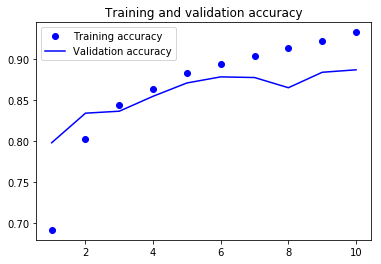

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
min_val_acc=np.min(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs[0:], acc[0:], 'bo', label='Training accuracy')
plt.plot(epochs[0:], val_acc[0:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

## Bidirectional LSTM architecture with Attention
### Define Custom Attention Layer
Since Keras does not provide an attention-layer, we have to implement this type on our own. The general concept of writing custom Keras layers is described in the corresponding [Keras documentation](https://keras.io/layers/writing-your-own-keras-layers/). 

Any custom layer class inherits from the layer-class and must implement three methods:

- `build(input_shape)`: this is where you will define your weights. This method must set `self.built = True`, which can be done by calling `super([Layer], self).build()`.
- `call(x)`: this is where the layer's logic lives. Unless you want your layer to support masking, you only have to care about the first argument passed to call: the input tensor.
- `compute_output_shape(input_shape)`: in case your layer modifies the shape of its input, you should specify here the shape transformation logic. This allows Keras to do automatic shape inference.

In [21]:
from keras import regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

### Prepare Embedding Matrix and -Layer

In [22]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

### Define Architecture

In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_gru = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = Attention(MAX_SEQUENCE_LENGTH)(l_gru)
preds = Dense(2, activation='softmax')(l_att)
model = Model(sequence_input, preds)

### Train Network

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['categorical_accuracy'])

In [18]:
print("model fitting - attention GRU network")
model.summary()
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=10, batch_size=50)

model fitting - attention GRU network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 100)         8150400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 200)         120600    
_________________________________________________________________
attention_1 (Attention)      (None, 200)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 8,272,602
Trainable params: 122,202
Non-trainable params: 8,150,400
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [===============

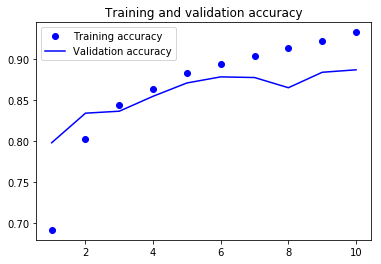

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
min_val_acc=np.min(val_acc)

epochs = range(1, len(acc) + 1)

plt.figure()

plt.plot(epochs[0:], acc[0:], 'bo', label='Training accuracy')
plt.plot(epochs[0:], val_acc[0:], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()